### Setup

In [2]:
%matplotlib inline

import SimpleITK as sitk
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath('..'))
import config 

print("Environment initialized.")


TARGET_CORE = "Core_01"  # Replace with your specific test core
CHANNEL_IDX = 6          # 6 for CK, 0 for DAPI

DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
INPUT_FOLDER = os.path.join(DATA_BASE_PATH, TARGET_CORE)

if not os.path.exists(INPUT_FOLDER):
    raise FileNotFoundError(f"Input folder not found: {INPUT_FOLDER}")

print(f"Targeting Core: {TARGET_CORE}")
print(f"Data Path: {INPUT_FOLDER}")

Environment initialized.
Targeting Core: Core_01
Data Path: /data3/junming/3D-TMA-Register/TMA_Cores_Grouped_NEW/Core_01


### Functions

In [3]:
def get_slice_number(filename):
    """Extracts Z-slice number from filename for chronological sorting."""
    match = re.search(r"TMA_(\d+)_", os.path.basename(filename))
    return int(match.group(1)) if match else 0 

def generate_qc_montage_inline(vol, channel_idx, prefix):
    """
    Generates an inline pairwise montage (Z vs Z+1) for notebook visualization.
    """
    n_slices = vol.shape[0]
    if n_slices < 2: 
        print("Not enough slices for montage.")
        return

    all_pairs = [(i, i+1) for i in range(n_slices - 1)]
    n_pairs = len(all_pairs)
    n_cols = 5 
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    
    # Standardize axes array shape
    if n_rows == 1 and n_cols == 1: axes = np.array([[axes]])
    elif n_rows == 1: axes = axes.reshape(1, -1)
    elif n_cols == 1: axes = axes.reshape(-1, 1)
    axes_flat = axes.flatten()

    for idx, (z1, z2) in enumerate(all_pairs):
        s1 = vol[z1, channel_idx, :, :]
        s2 = vol[z2, channel_idx, :, :]
        
        # 99.5th percentile normalization to handle intensity outliers
        def norm(x):
            p99 = np.percentile(x, 99.5)
            if p99 == 0: p99 = 1
            return np.clip(x / p99, 0, 1)
        
        # Red/Green Overlay mapping: Red = Z+1, Green = Z
        overlay = np.dstack((norm(s1), norm(s2), np.zeros_like(s1)))
        
        ax = axes_flat[idx]
        ax.imshow(overlay)
        ax.set_title(f"Z{z1} -> Z{z2}", fontsize=10, fontweight='bold')
        ax.axis('off')

    # Turn off axes for empty subplots
    for idx in range(len(all_pairs), len(axes_flat)): 
        axes_flat[idx].axis('off')
        
    plt.suptitle(f'Raw Alignment Overlay: {TARGET_CORE} (Channel {channel_idx})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Data Loading and Execution

Standardizing spatial dimensions to Maximum (Y: 6176, X: 6176)...
Volume constructed successfully. Shape: (20, 8, 6176, 6176)


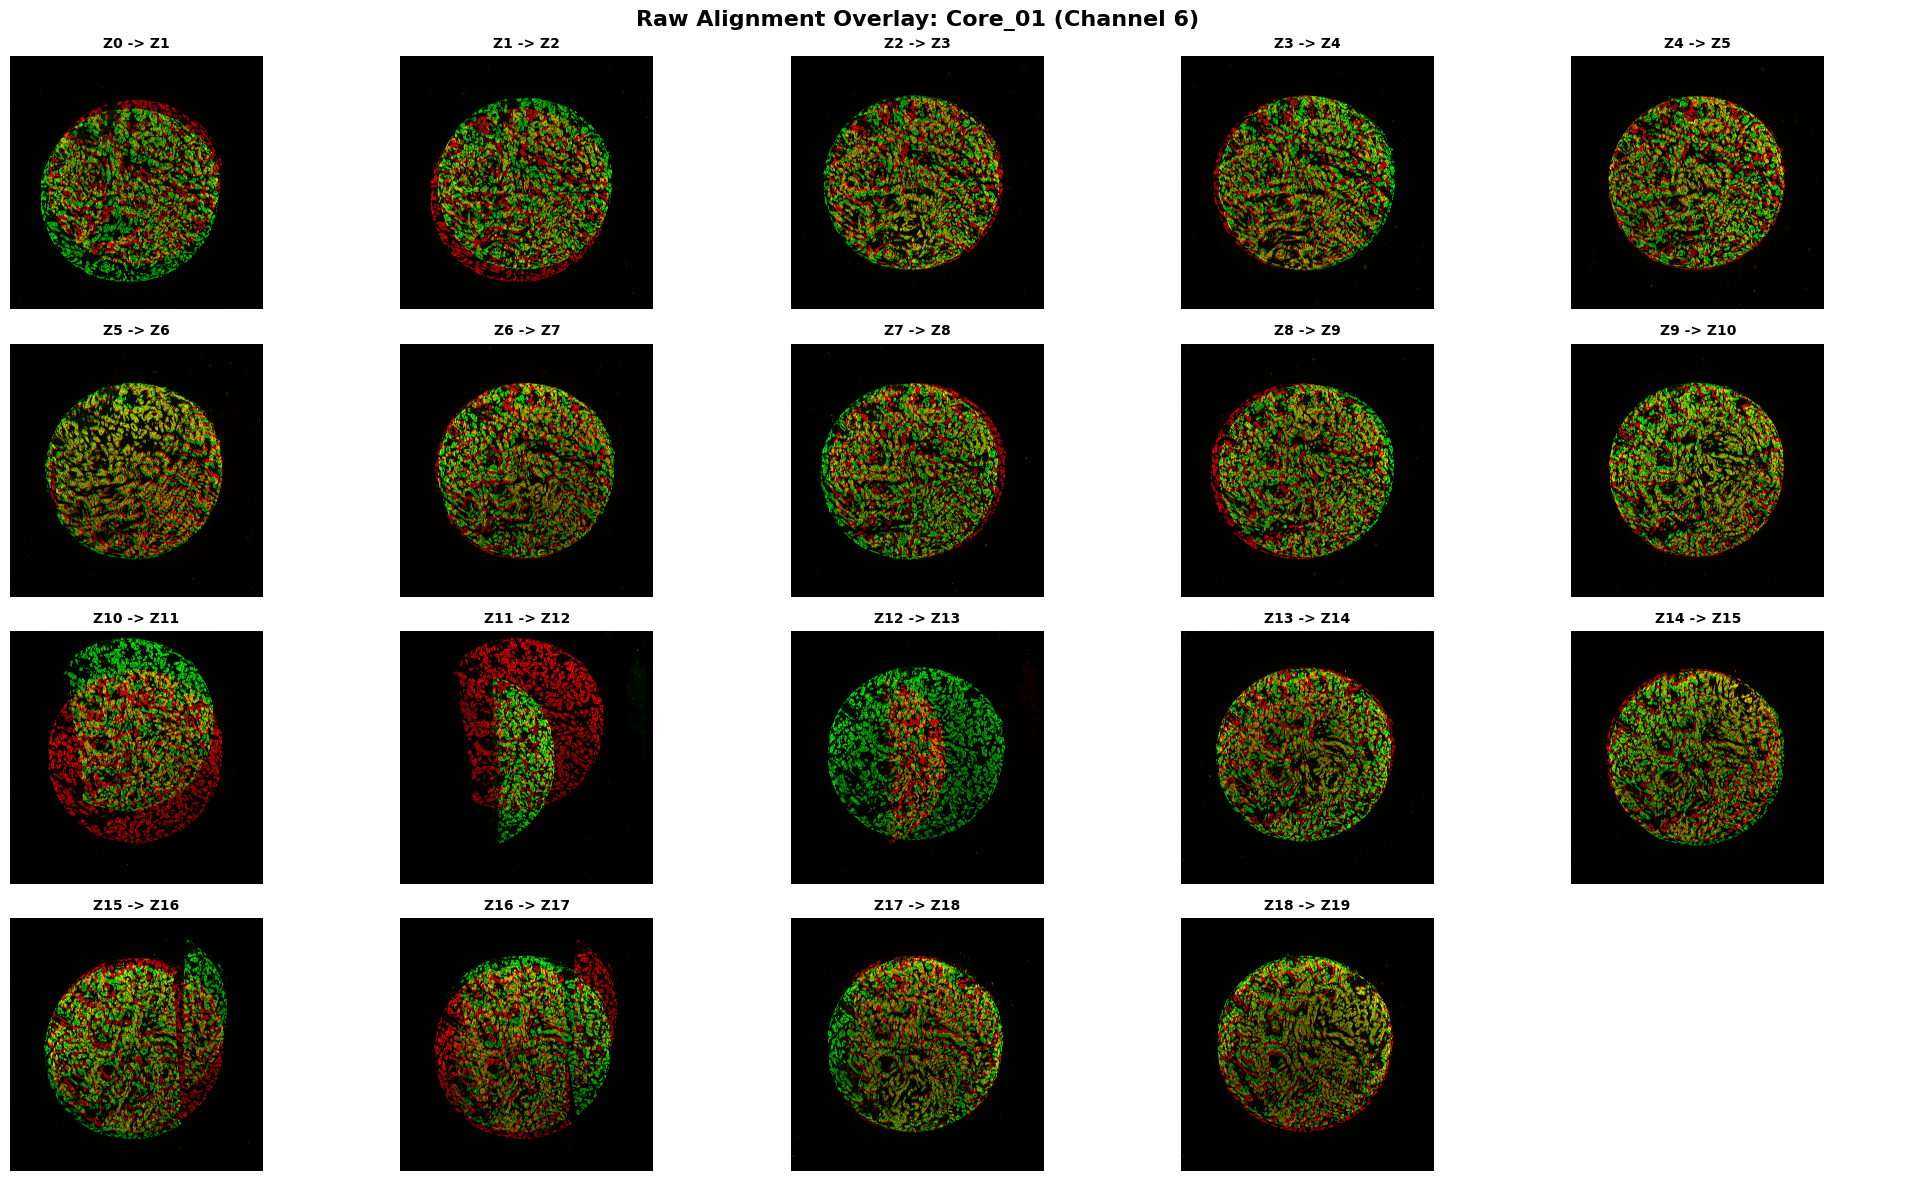

: 

In [ ]:
# --- UPDATE FOR CELL 4: DIMENSIONAL STANDARDIZATION ---

# 1. Determine the maximum spatial dimensions across all slices
# Assuming array shape is (C, Y, X) based on previous logs
max_y = max(arr.shape[1] for arr in loaded_arrays)
max_x = max(arr.shape[2] for arr in loaded_arrays)

print(f"Standardizing spatial dimensions to Maximum (Y: {max_y}, X: {max_x})...")

# 2. Pad arrays to match the maximum dimensions
standardized_arrays = []
for arr in loaded_arrays:
    c, y, x = arr.shape
    
    # Calculate required padding
    pad_y = max_y - y
    pad_x = max_x - x
    
    # Pad only the spatial dimensions (Y and X) with zeros (constant value 0)
    # np.pad format: ((before_c, after_c), (before_y, after_y), (before_x, after_x))
    padded_arr = np.pad(arr, ((0, 0), (0, pad_y), (0, pad_x)), mode='constant', constant_values=0)
    standardized_arrays.append(padded_arr)

# 3. Construct 4D volume: (Z, C, Y, X)
try:
    vol = np.array(standardized_arrays)
    print(f"Volume constructed successfully. Shape: {vol.shape}")
except ValueError as e:
    raise RuntimeError(f"Critical dimension failure after padding. Error: {e}")

# Render the montage
generate_qc_montage_inline(vol, channel_idx=CHANNEL_IDX, prefix="RAW_Overlay")